In [1]:
import pandas as pd
import numpy as np 
import matplotlib as mlp 
from matplotlib import pyplot as plt 
import geopandas as gp
import xlrd 
import os
import seaborn as sns
import re

%matplotlib inline

In [2]:
os.chdir("../../core")
import GT_helper_functions as hf
import GT_load_data as data

base_dir = "../../"

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200
sns.set_style("whitegrid")

In [4]:
def tryFunc(f, defValue = np.NaN):
    def wrap(i):
        try:
            return f(i)
        except:
            return defValue
    return wrap 

def nextCell(row, offset = 0):
    lenr = len(row)
    if offset >= lenr:
        return None
    while (offset+1 < lenr) & (row[offset].ctype == xlrd.XL_CELL_EMPTY):
        offset += 1
    return offset

In [5]:
colsrefs = None
def SICOIN_extractInput(filename):
    global colsrefs
    xlsfile = xlrd.open_workbook(filename)
    sheet = xlsfile.sheet_by_index(0)
    year = sheet.cell_value(rowx = 11, colx = 8)
    i = 19
    data = []
    continuousEmpty = 0
    while True:
        i += 1
        if i >= sheet.nrows:
            break
            
        row = sheet.row(i)
        if (row[0].ctype == xlrd.XL_CELL_EMPTY):
            continuousEmpty += 1
            if continuousEmpty > 100:
                break
            else:
                continue
        
        continuousEmpty = 0
        j = 0
        rowData = []
        if (colsrefs is None):
            colsrefs = []
            while True:
                colsrefs.append(j)
                value = str(row[j].value).strip()
                rowData.append(value)
                j = nextCell(row, j+1)
                if j is None:
                    break
        else:
            rowData = [ str(row[r].value).strip() for r in colsrefs ]
        data.append(rowData)
        
    return pd.DataFrame(data, columns = sicoin_cols).assign(Year = year)
sicoin_cols = [
    "Entidad",
    "CUR",
    "ORI",
    "DocumentoRespaldo",
    "Fuente",
    "FechaElaboracion",
    "FechaReal",
    "EtapaReg",
    "ClaseMod",
    "UbicacionGeog",
    "CuentaCorriente",
    "Descripcion",
    "Banco",
    "Monto",
    "AprobadoSt", "AprobadoFecha",
    #"RevertidoSt", "RevertidoFecha",
    "CodError"
]

In [157]:
dataset = None

for root, dirs, files in os.walk("../../Resource Tracking/SICOIN GT/Ingresos/"):
    for file in files:
        if file.endswith(".xls") & file.startswith("SICOIN - CUR Detallado Ingresos"):
            temp = SICOIN_extractInput(root + file)
            print("Extracted ", file, " with nrows = ", len(temp), ". ")
            if dataset is None:
                dataset = temp
            else:
                dataset = pd.concat([dataset, temp])
                

Extracted  SICOIN - CUR Detallado Ingresos - 0425,2102 2009.xls  with nrows =  22 . 
Extracted  SICOIN - CUR Detallado Ingresos - 0425,2102 2010.xls  with nrows =  23 . 
Extracted  SICOIN - CUR Detallado Ingresos - 0425,2102 2011.xls  with nrows =  8 . 
Extracted  SICOIN - CUR Detallado Ingresos - 0425,2102 2012.xls  with nrows =  18 . 
Extracted  SICOIN - CUR Detallado Ingresos - 0425,2102 2013.xls  with nrows =  10 . 
Extracted  SICOIN - CUR Detallado Ingresos - 0425,2102 2014.xls  with nrows =  16 . 
Extracted  SICOIN - CUR Detallado Ingresos - 0425,2102 2015.xls  with nrows =  7 . 
Extracted  SICOIN - CUR Detallado Ingresos - 0425,2102 2016.xls  with nrows =  7 . 
Extracted  SICOIN - CUR Detallado Ingresos - 0425,2102 2017.xls  with nrows =  9 . 
Extracted  SICOIN - CUR Detallado Ingresos - 0425,2102 2018.xls  with nrows =  35 . 


In [174]:
dataset.AprobadoSt.value_counts()

S    47
N     1
Name: AprobadoSt, dtype: int64

In [160]:
dataset["Monto"] = dataset.Monto.astype(float)

In [161]:
# From SICOIN execution data, I have got the following sum for the spending, from 2011 to 2018:
4.66+31.63+31.41+35.09+35.98+14.32+11.96+14.25, 196-179

(179.3, 17)

In [164]:
grantsFM = ["61 - 0425 - 0001", "61 - 2102 - 0013", "61 - 0425 - 0002", "61 - 02102 - 0013", "61 - 0425 - 0003"]
dataset["GF"] = dataset.Fuente.isin(grantsFM)

In [163]:
dataset["Grant"] = dataset.Descripcion.map(tryFunc(lambda x: re.findall("((\w+\-){2}(\w+\-)*\w+)", x)[0][0], "" ))

                Monto                                                   \
Grant  FM-GTM-T-MSPAS FM-GUA-311-G06-H FM-GUA-610-G04-T FM-GUA-M-MSPAS   
Year                                                                     
2010.0           0.00             0.00             0.00           0.00   
2011.0           0.00            38.28             0.00          27.97   
2012.0           0.00             0.00             0.78          22.07   
2013.0           0.00             0.00             5.38           0.00   
2014.0           0.00            18.24             1.01          25.72   
2015.0           0.00             4.05             0.28          12.84   
2016.0           2.80             5.93             0.00           6.02   
2017.0           1.09             2.43             0.00           6.32   
2018.0           5.40             0.00             0.00           7.80   

                      
Grant  GUA-610-G04-T  
Year                  
2010.0          9.49  
2011.0          6.8

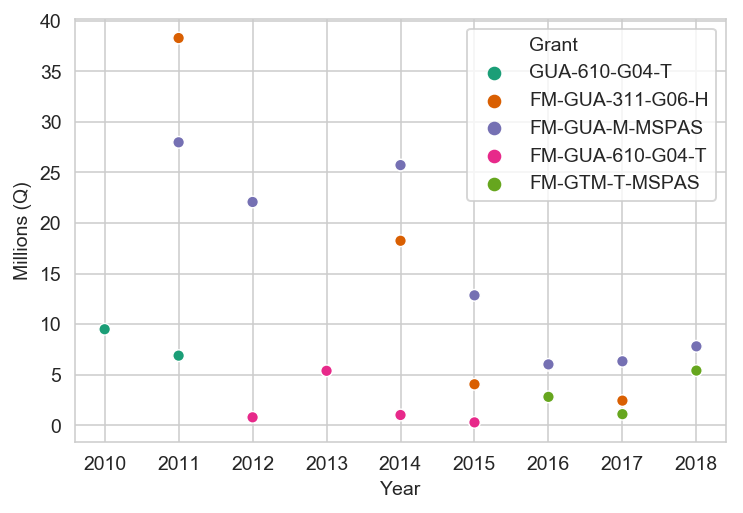

In [183]:
mlp.rcParams["figure.dpi"] = 140
temp = dataset[dataset.GF & (dataset.AprobadoSt == "S")].groupby(["Year", "Grant"]).Monto.sum()/1000000 #.unstack(1).fillna(0)
temp = temp.reset_index()
gs = temp.Grant.unique()
pal = sns.color_palette("Set1", n_colors = len(gs))
levelsColors = dict(zip(gs, pal))

#temp.plot.scatter(x = "Year", y = "Monto", c = [levelsColors[x] for x in temp.Grant.values], colormap="viridis")
#pd.DataFrame.plot.scatter()
sns.scatterplot("Year", "Monto", "Grant", data = temp, palette="Dark2")
plt.ylabel("Millions (Q)")
print(temp.set_index(["Year", "Grant"]).unstack(1).fillna(0).round(2))

(Year
 2010.0     9489980.57
 2011.0    73136342.98
 2012.0    22854644.62
 2013.0     5381331.48
 2014.0    44969335.38
 2015.0    17173403.14
 2016.0    14753170.78
 2017.0     9847408.26
 2018.0    13200695.84
 Name: Monto, dtype: float64, 201316332.48)

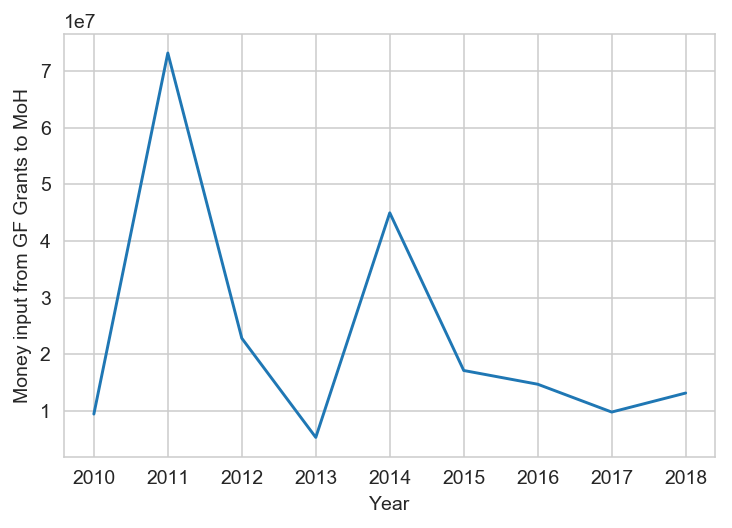

In [177]:
mlp.rcParams["figure.dpi"] = 140
temp = dataset[dataset.GF & (dataset.AprobadoSt == "S")
              ].groupby("Year").Monto.sum()
temp.plot()
plt.ylabel("Money input from GF Grants to MoH")
temp, temp[temp.index>2010].sum()

In [178]:
# Filter out non GF grants
dataset = dataset[dataset.GF & (dataset.AprobadoSt == "S")]

In [179]:
dataset.to_csv("../../Resource Tracking/SICOIN GT/SICOIN GF Inputs - 2010-2018.csv")